# A Simple Sine Wave Example

This jupyter notebook helps to  demonstrate the use of Long Short-Term ( [LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)) Neural Networks in predicting a  simple sine function time series data.  That is we  start with the most basic thing we can think of,  that's a time series: the trusty sine wave. 

The data provided file name sinewave.csv

The  reference code/notebook i used can be found  [here](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)

Any comments or suggestions are welcome!

In [1]:
#Adding the following lines to a new script will clear all variables each time you rerun the script
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
# handle uncessary warnings
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
fxn()

/nethome/gzewdie3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: deprecated
  """


In [4]:
#import useful libraries
import warnings
import time 
import numpy as np 
import pandas as pd
from keras import optimizers 
from keras.utils import plot_model 
from keras.models import Sequential, Model 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
from timeit import Timer

Using TensorFlow backend.


In [5]:
#import plotiing libraries!
import matplotlib.pyplot as plt 
from pylab import rcParams
import seaborn as sns
import chart_studio.plotly as py 
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode, iplot

In [6]:
%matplotlib inline 
init_notebook_mode(connected=True)

In [7]:
#import tensorflow and seed 
import tensorflow as tf
tf.random.set_seed(1)

This example of applying the LSTM helps us to demonstrate deep neural networks (LSTM) in predicting a time series data.  We start by importing the sinewave data (or you can create it here with a few lines of code). The sinewave function is a good example to show the performance of LSTM.  The following lines exhibt the data.

In [8]:
#read the sine wave csv data  
sineData=pd.read_csv('sinewave.csv')

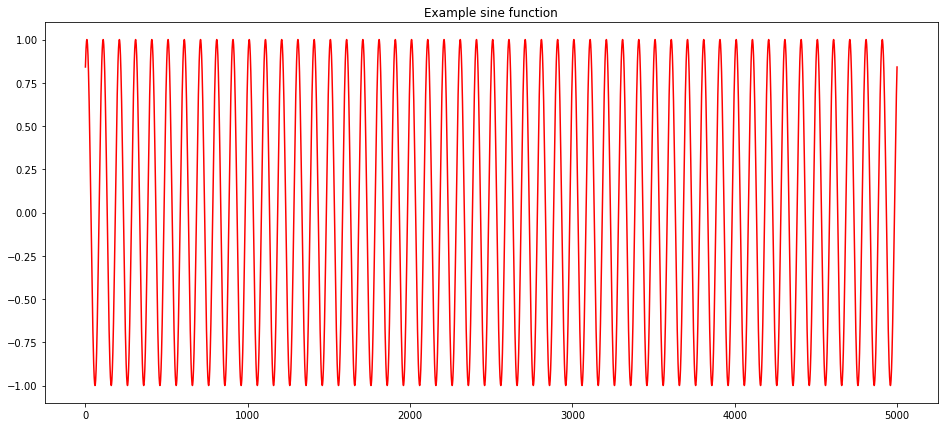

In [9]:
#plot all sine wave data 
plt.figure(figsize=(16,7))
plt.plot(sineData['sinewave'],'r')
plt.title('Example sine function')
plt.show()

In [10]:
print('The shape of the sine wave  data is {}'.format(sineData.shape))

The shape of the sine wave  data is (5001, 1)


In [11]:
sineData.head()

,sinewave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [12]:
sineData.shape

(5001, 1)

Our objective here is to teach the LSTM sign wave series using a window size of data and we are hoping it will predict the next number of steps in the series. We hope it will keep producing the sine wave data, at least for the first few series. 

We started  by transforming and loading the data from the CSV file to a pandas dataframe which will then be used to output a numpy array that will be input  to the LSTM. The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions (N, W, F) where N is the number of training sequences, W is the sequence length and F is the number of features of each sequence. We chose to go with a sequence length (read window size) of 50 which allows for the network so get glimpses of the shape of the sine wave at each sequence and hence will hopefully teach itself to build up a pattern of the sequences based on the prior window received.


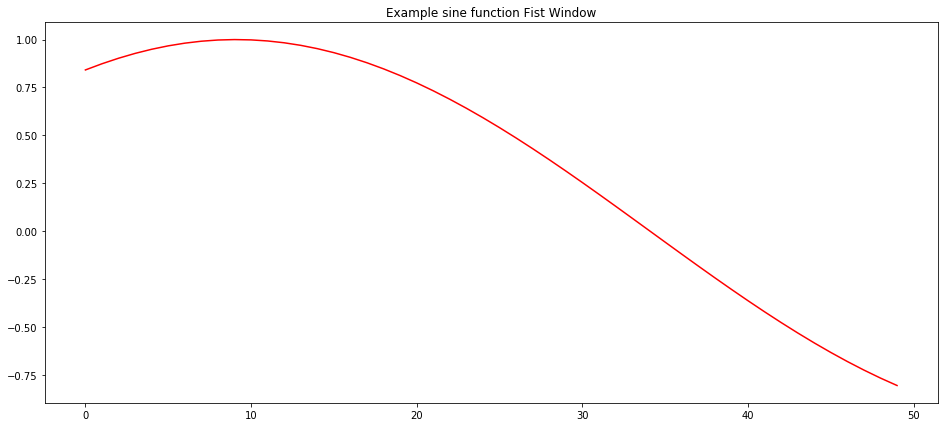

In [13]:
# Plot window size. Is this a good window  so that LSTM can get a glipse of the sequence?
plt.figure(figsize=(16,7))
plt.plot(sineData['sinewave'][:50],'r')
plt.title('Example sine function Fist Window')
plt.show()

In [14]:
#function to normalize the data 
def to_Normalize(df_data):
    scaler=MinMaxScaler(feature_range=(-1,1))
    df=scaler.fit_transform(df_data)
    return scaler, df

In [15]:
#Normalize Data 
scaler, sineDataScaled=to_Normalize(sineData)

In [16]:
# Check if properly normalized!
print('Max  %.7f' % sineDataScaled.max())
print('Min %.7f' %sineDataScaled.min())

Max  1.0000000
Min -1.0000000


In [17]:
#function to split the data into training and test sets!
def split_data(df,i_split):
    train_size=int(len(df)*i_split)
    test_size=len(df)-train_size
    data_train=sineDataScaled[:train_size]
    data_test=sineDataScaled[train_size:]
    print('The shape of training data is {}'.format(np.shape(data_train)))
    print('The shape of testing data is {}'.format(np.shape(data_test)))
    return data_train, data_test
    

In [18]:
split_s=0.85
data_train,data_test=split_data(sineDataScaled,split_s)

The shape of training data is (4250, 1)
The shape of testing data is (751, 1)


In [19]:
# Convert the time series data into supervised!! Do I need to use seq_len or seq_len-1 in the for loop
def to_supervised(dataSet, seq_len):
    data_x,data_y=[],[]
    for ii in range(len(dataSet)-seq_len):
             
        a=dataSet[ii:(ii+seq_len),0]
        data_x.append(a)
        data_y.append(dataSet[ii + seq_len, 0])
#         print(ii)
#         if ii>5:
#             stop
        
    return np.array(data_x),np.array(data_y)

In [20]:
window=50
train_x,train_y=to_supervised(data_train,window)
test_x,test_y=to_supervised(data_test,window)

In [21]:
# LSTM wants the data in the sahpe of (N,W,F) where 
#N is the number of training sequences, W is the sequence length and F: number of features of each sequence. 
#In our case (N=4200(701),W=50, F=1)
def to_reshape(dataX):
    data_xx=np.reshape(dataX,(dataX.shape[0],dataX.shape[1],1))
    print('The shape of of the data is: {}'.format(data_xx.shape))
    return data_xx
    

In [22]:
train_x=to_reshape(train_x)
test_x=to_reshape(test_x)

The shape of of the data is: (4200, 50, 1)
The shape of of the data is: (701, 50, 1)


In [23]:
# Le us build the model 
model=Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
# Fit the model, and print the time it takes to trian.
t0 = time.time()
model.fit(train_x,train_y, validation_data=(test_x, test_y),epochs = 10, validation_split=0.04)

t1 = time.time()

total = t1-t0
print('Total time taken to fit the model is {} '.format(total))

Train on 4200 samples, validate on 701 samples
Epoch 1/10
4200/4200 [==============================] - 9s 2ms/step - loss: 0.0252 - val_loss: 3.1941e-04
Epoch 2/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0039 - val_loss: 4.3636e-04
Epoch 3/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0035 - val_loss: 1.8771e-04
Epoch 4/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0039 - val_loss: 5.1874e-04
Epoch 5/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0035 - val_loss: 8.6312e-04
Epoch 7/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 8/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0029 - val_loss: 3.5129e-04
Epoch 9/10
4200/4200 [==============================] - 8s 2ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 10/10

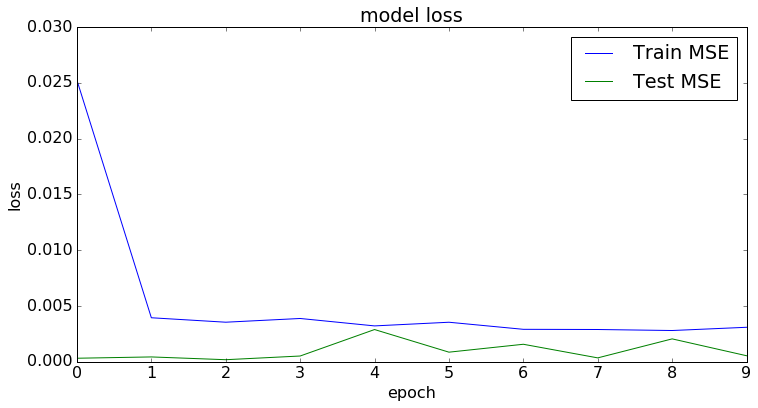

In [25]:
#plot the training and test loss!
plt.style.use('classic')
%matplotlib inline
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train MSE', 'Test MSE'], loc='upper right')
plt.show()

fig.savefig('modelLoss.png', dpi=500)

In [26]:
# make predictions for the trainig and test sets
trainPredict = model.predict(train_x)
model.reset_states()
testPredict = model.predict(test_x)

In [27]:
testPredict.shape

(701, 1)

In [28]:
# scale back the predicted data
trainPredict = scaler.inverse_transform(pd.DataFrame(trainPredict))
trainY = scaler.inverse_transform(pd.DataFrame(train_y))
testPredict = scaler.inverse_transform(pd.DataFrame(testPredict))
testY = scaler.inverse_transform(pd.DataFrame(test_y))

In [29]:
testPredict.max()

1.021858592962166

In [30]:
# testY=test_y
# trainY=train_y

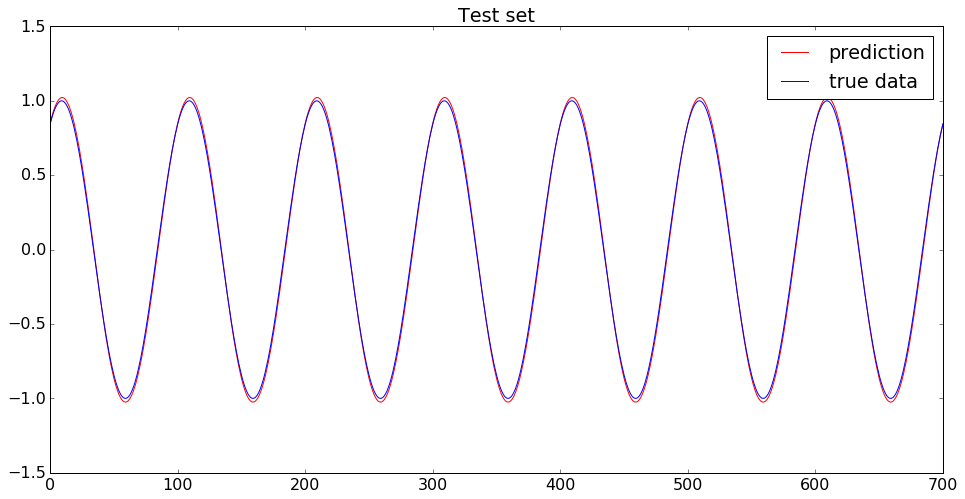

In [31]:
# plot the prediction and the test set together. NB in this case the prediction is done in a point-by-point way, 
#that is we are predictiong a single point a head each time! plotting this point as a prediction, then taking 
#the next window along with the full testing data and predicting the next point along once again. 
plt.figure(figsize=(16,8))
plt.plot(testPredict,'r', label='prediction')
plt.plot(testY,'b',label='true data')
plt.title('Test set')
plt.legend()
plt.show()

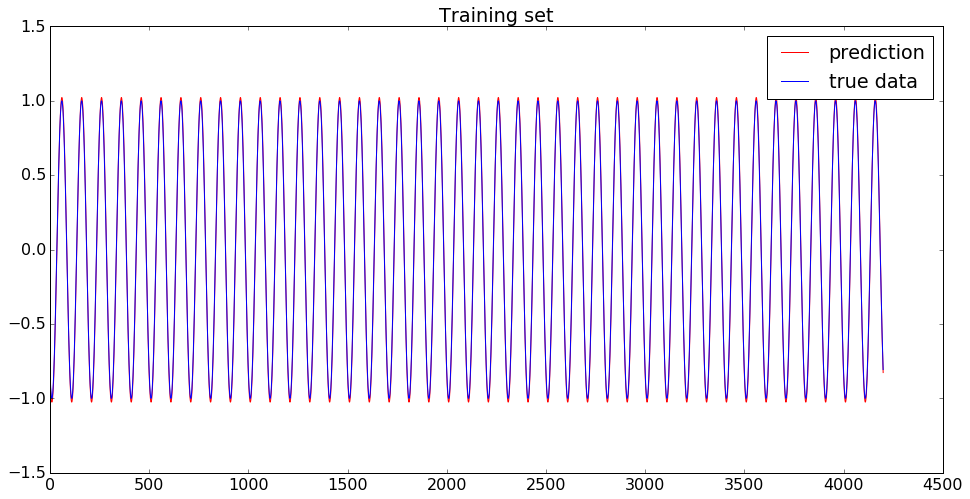

In [32]:
# Prediction for the trainig  set
plt.figure(figsize=(16,8))
plt.plot(trainPredict,'r', label='prediction')
plt.plot(trainY,'b',label='true data')
plt.title('Training set')
plt.legend()
plt.show()

In [33]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.8f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.8f RMSE' % (testScore))

Train Score: 0.02333940 RMSE
Test Score: 0.02332363 RMSE


This is  a point-by-point prediction, that is we are only predicting a single point ahead each time, plotting this point as a prediction, then taking the next window along with the full testing data and predicting the next point along once again.

This has taught me a lot! Next is to predict a full sequence, by this we only initialize a training window with the first part of the training data once. The model then predicts the next point and we shift the window, as with the point-by-point method. The difference is we then predict using the data that we predicted in the prior prediction. In the second step this will mean only one data point (the last point) will be from the prior prediction. In the third prediction the last two data points will be from prior predictions and so forth. After 50 (length of window) predictions our model will subsequently be predicting on its own prior predictions. This allows us to use the model to forecast many time steps ahead, but as it is predicting on predictions which can then in turn be based on predictions this will increase the error rate of the predictions the further ahead we predict. 

In [34]:
#This function is  to forecast as many time  steps a head as we can  
steps_ahead=100
def predict_sequence_full(dataSet,window):
    #shift the window by 1 new prediction each time, re-run predictiosn on the new window
    curr_frame=dataSet[0]
    predicted=[]
    rmse_error=[]
    for ii in range(len(dataSet)+steps_ahead):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        #print(type(predicted))
        if ii<len(testY):
            #print(ii)
            rmse_err=np.sqrt(mean_squared_error(np.array(predicted),testY[:ii+1]))
            rmse_error.append(rmse_err)
        #print(len(predicted))
        curr_frame=curr_frame[1:]
        curr_frame=np.insert(np.array(curr_frame),[window-1],predicted[-1],axis=0)
    return predicted,rmse_error
    

In [35]:
predictions_fullseq,rmse_error =predict_sequence_full(test_x, window)

In [36]:
predictions_fullseqNP=np.array(predictions_fullseq)

In [37]:
predictions_fullseqNP=predictions_fullseqNP.reshape(len(predictions_fullseq),1)

In [38]:
predictions_fullseq_x = scaler.inverse_transform(pd.DataFrame(predictions_fullseqNP))


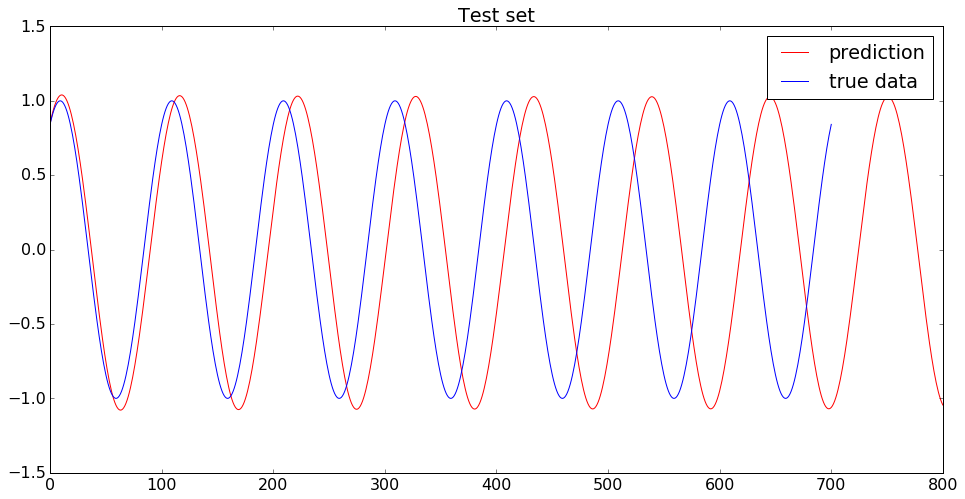

In [39]:
plt.figure(figsize=(16,8))
plt.plot(predictions_fullseq_x,'r', label='prediction')
plt.plot(testY,'b',label='true data')
#plt.xlim(0,400)
plt.title('Test set')
plt.savefig('SineFunctionForecast.png', facecolor='w', format='png')
plt.legend()
plt.show()

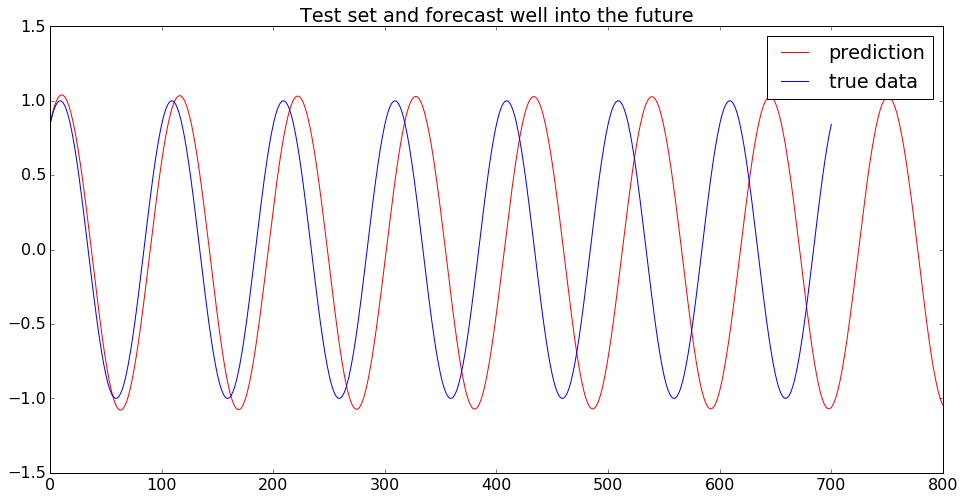

In [40]:
plt.figure(figsize=(16,8))
plt.plot(predictions_fullseq_x,'r', label='prediction')
plt.plot(testY,'b',label='true data')
#plt.xlim(0,400)
plt.title('Test set and forecast well into the future')
plt.savefig('SineFunctionForecastall.png', facecolor='w', format='png')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.show()

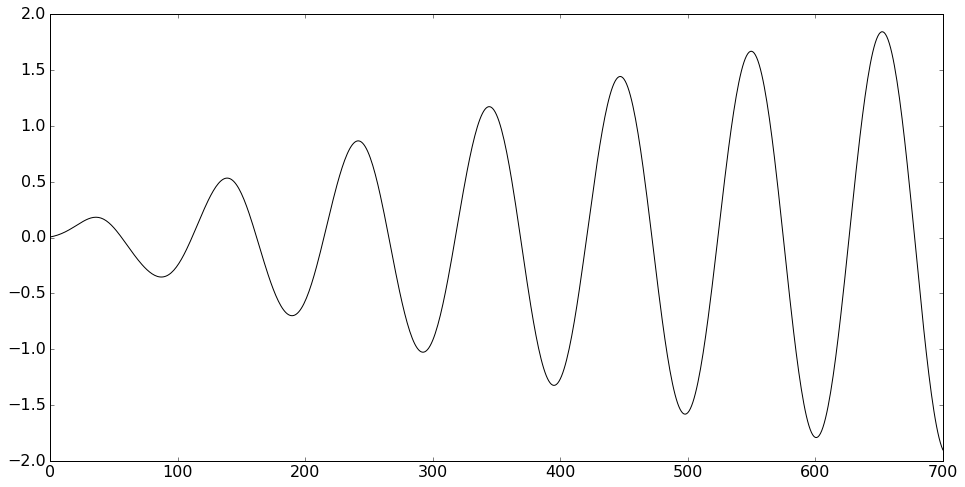

In [41]:
plt.figure(figsize=(16,8))
plt.plot(predictions_fullseq_x[0:len(testY)]-testY,'k')
plt.rcParams.update({'font.size': 16})
plt.show()

We clearly see in the above figure that as the number of steps to predict in the future increast the error rate increases by a large amount.  That is the LSTM forecasts well in to the near future and fails as we try to forecast well into the future!

In [42]:
# function to forecast into the future!
def calculate_rmse(prediction, test):
    rmse_error=[]
    for k in range(len(testY)):
        #print(k)
        rmse_err=np.sqrt(mean_squared_error(prediction[:k+1],test[:k+1]))
        rmse_error.append(rmse_err)
    return rmse_error
        

In [43]:
rmse_error_new=calculate_rmse(predictions_fullseq_x,testY)

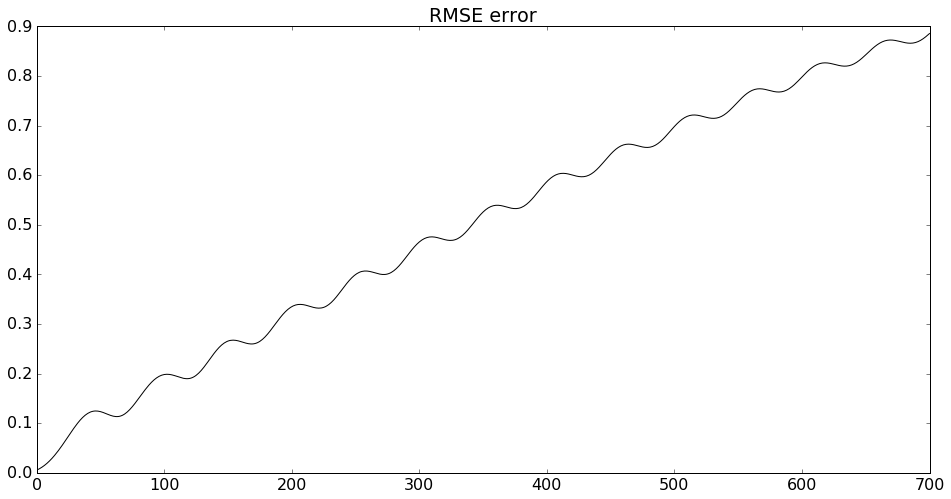

In [44]:
plt.figure(figsize=(16,8))
plt.plot(rmse_error,'k')
plt.title('RMSE error')
plt.rcParams.update({'font.size': 16})
plt.show()

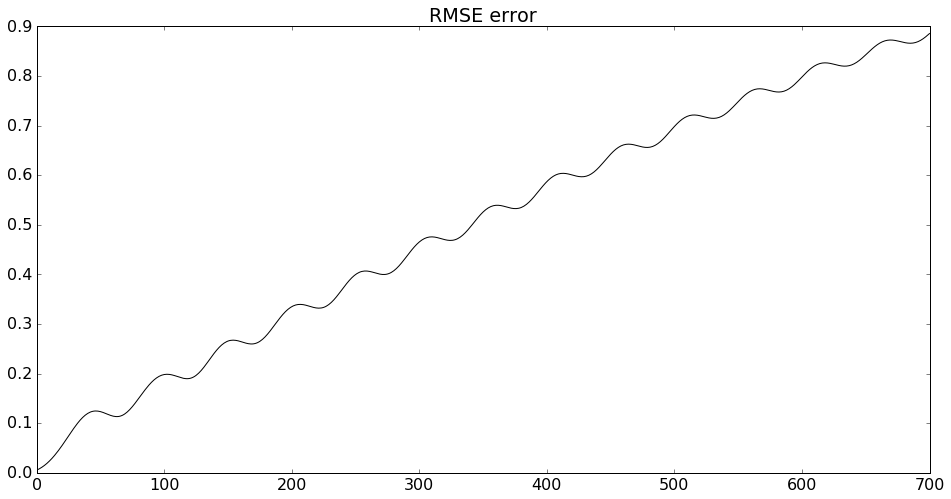

In [45]:
plt.figure(figsize=(16,8))
plt.plot(rmse_error_new,'k')
plt.title('RMSE error')
plt.rcParams.update({'font.size': 16})
plt.show()